In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from models.scripts.utils import load_csv, split_date, drop_columns, impute_rolling_median, add_seasonality, apply_moving_average_for_roc, split_data_frame, apply_functions

### Preprocessing

In [2]:
df = load_csv('../../data/btc_timeseries.csv')
df = split_date(df, 'time')
df = drop_columns(df, 10.0)
df = impute_rolling_median(df, 5)
df = add_seasonality(df)
df = apply_moving_average_for_roc(df, 'ema', 10, 20)
df = df.ffill()

/Users/lucapetracca/Documents/GitHub/Transformers-Financial-Time-Series-Forecasting/models/scripts/utils.py:153: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column].fillna(method='bfill', inplace=True)  # Backfill to address initial NaNs


In [3]:
columns_to_keep = ['timestamp', 'time', 'open', 'close', 'high', 'low', 'volume_24h', 'market_cap', 'social_contributors', 'social_volume', 'tweets', 'day', 'month', 'year', 'Month_Category_Bearish', 'Month_Category_Bullish', 'Month_Category_Normal', 'ROC_0', 'ROC_1', 'ROC_2']

# Drop columns not in the columns_to_keep list
df = df[[col for col in df.columns if col in columns_to_keep]]

In [4]:
train, val, test = split_data_frame(df, 0.7, 0.2)

In [5]:
X_train, y_train, X_val, y_val, X_test, y_test = apply_functions(train, test, val)

/Users/lucapetracca/Documents/GitHub/Transformers-Financial-Time-Series-Forecasting/models/scripts/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_datetime(df[column], format="%d-%m-%Y")
/Users/lucapetracca/Documents/GitHub/Transformers-Financial-Time-Series-Forecasting/models/scripts/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_datetime(df[column], format="%d-%m-%Y")
/Users/lucapetracca/Documents/GitHub/Transformers-Financial-Time-Series-Foreca

In [72]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import Model as tfkModel

def build_LSTM_regressor(input_shape, output_units=1):
    # Define the input layer
    inputs = tfkl.Input(shape=input_shape, name='Input')

    # First LSTM layer with Dropout
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(inputs)
    x = tfkl.Dropout(0.2)(x)  # Dropout for regularization

    # Second LSTM Layer
    x = tfkl.LSTM(128, return_sequences=True)(x)
    x = tfkl.Dropout(0.2)(x)  # Additional dropout layer

    # Third LSTM layer
    x = tfkl.LSTM(64, return_sequences=False)(x)  # No return sequences to flatten the output

    # Dense layer before the final output
    x = tfkl.Dense(64, activation='relu')(x)

    # Output layer
    outputs = tfkl.Dense(output_units)(x)

    # Construct the full model
    model = tfkModel(inputs=inputs, outputs=outputs, name='Enhanced_LSTM_regressor')
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mape'])

    return model

In [73]:
def fit(X_train, y_train, X_val, y_val):
    # Convert the numpy arrays to float32
    X_train = X_train.astype('float32')
    y_train = y_train.astype('float32')
    X_val = X_val.astype('float32')
    y_val = y_val.astype('float32')

    # Assuming input_shape is (5, n_features)
    input_shape = (X_train.shape[1], X_train.shape[2])
    output_units = 1

    # Build and compile the model
    model = build_LSTM_regressor(input_shape, output_units)
    model.summary()

    # Train the model
    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=32,
        validation_data=(X_val, y_val),
        epochs=100,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
        ]
    ).history

    return model, history

In [74]:
model, history = fit(X_train, y_train, X_val, y_val)

Model: "Enhanced_LSTM_regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 5, 22)]           0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 5, 128)            44544     
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 5, 128)            0         
                                                                 
 lstm_10 (LSTM)              (None, 5, 128)            131584    
                                                                 
 dropout_7 (Dropout)         (None, 5, 128)            0         
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                           

In [75]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def evaluate(model, X_test, y_test):
    X_test = X_test.astype('float32')
    y_test = y_test.astype('float32')
    model.evaluate(X_test, y_test, verbose=1)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    return mse, mae, mape

def plot_results(model, X_test, y_test):

    X_test = X_test.astype('float32')
    y_test = y_test.astype('float32')
    model.evaluate(X_test, y_test, verbose=1)
    y_pred = model.predict(X_test)
    # Plotting
    plt.figure(figsize=(15, 6))
    plt.plot(y_test, label='Actual Values')
    plt.plot(y_pred, label='Predicted Values')
    plt.title('Comparison of Actual and Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

846/846 [==============================] - 4s 4ms/step


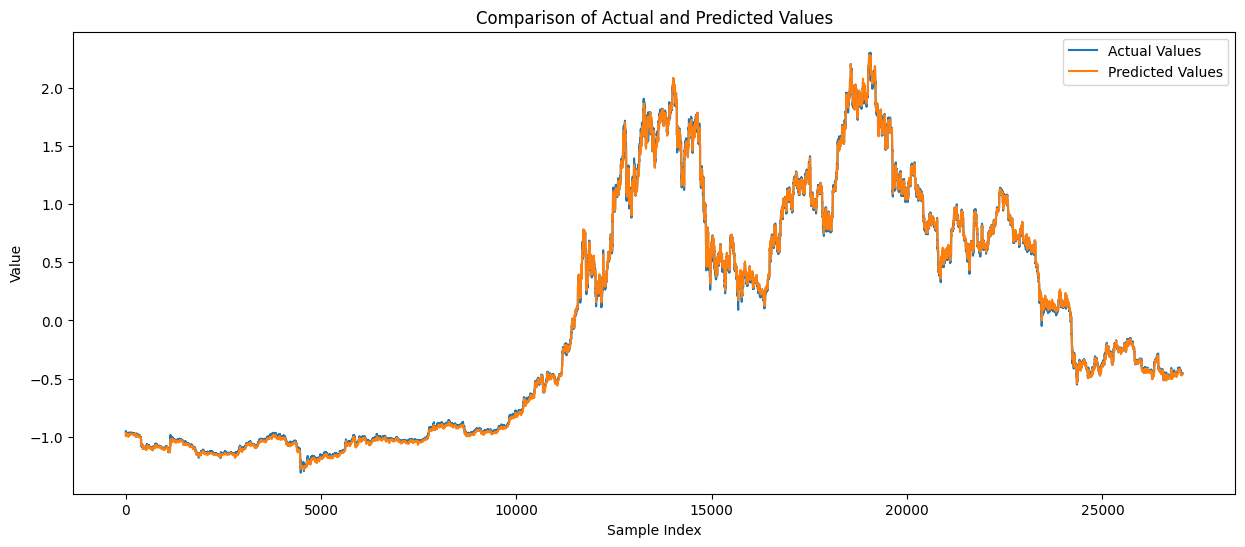

In [76]:
plot_results(model, X_train, y_train)

242/242 [==============================] - 1s 3ms/step


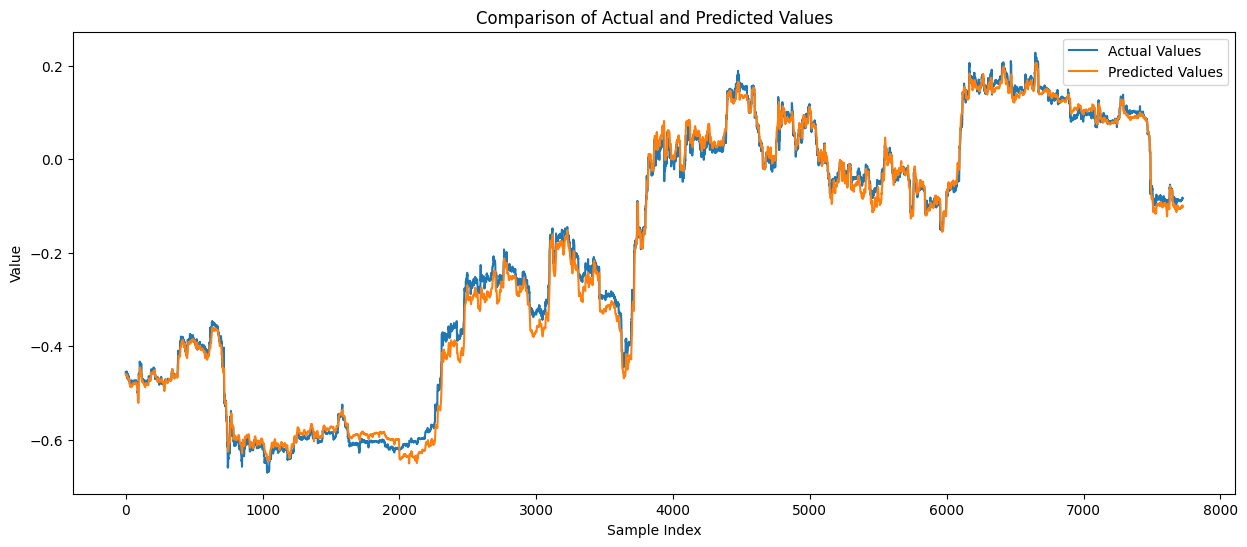

In [77]:
plot_results(model, X_val, y_val)

121/121 [==============================] - 0s 3ms/step


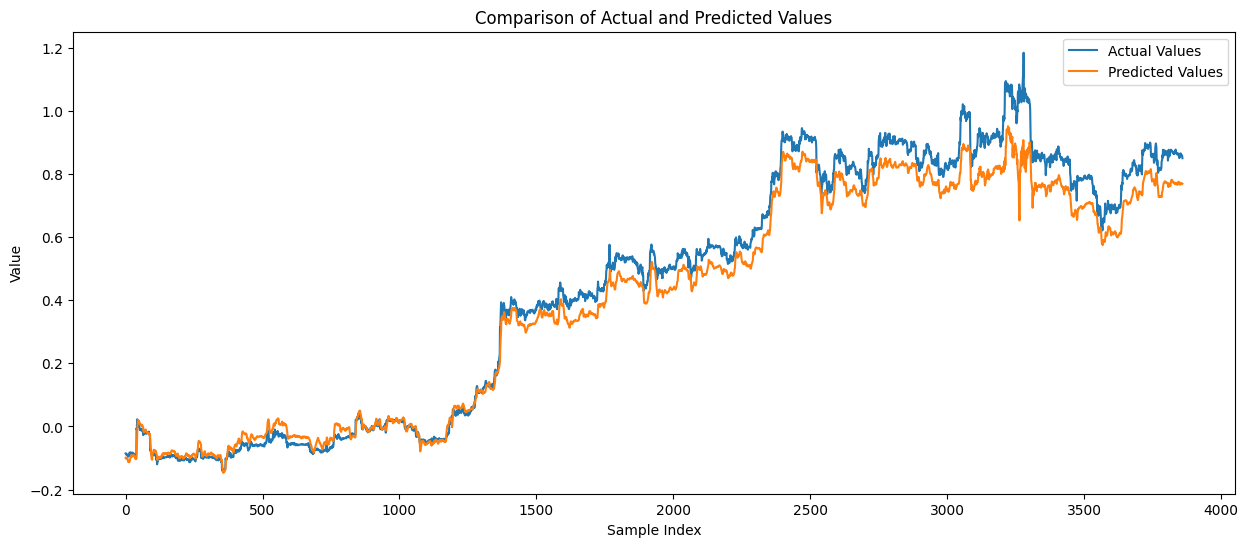

In [78]:
plot_results(model, X_test, y_test)

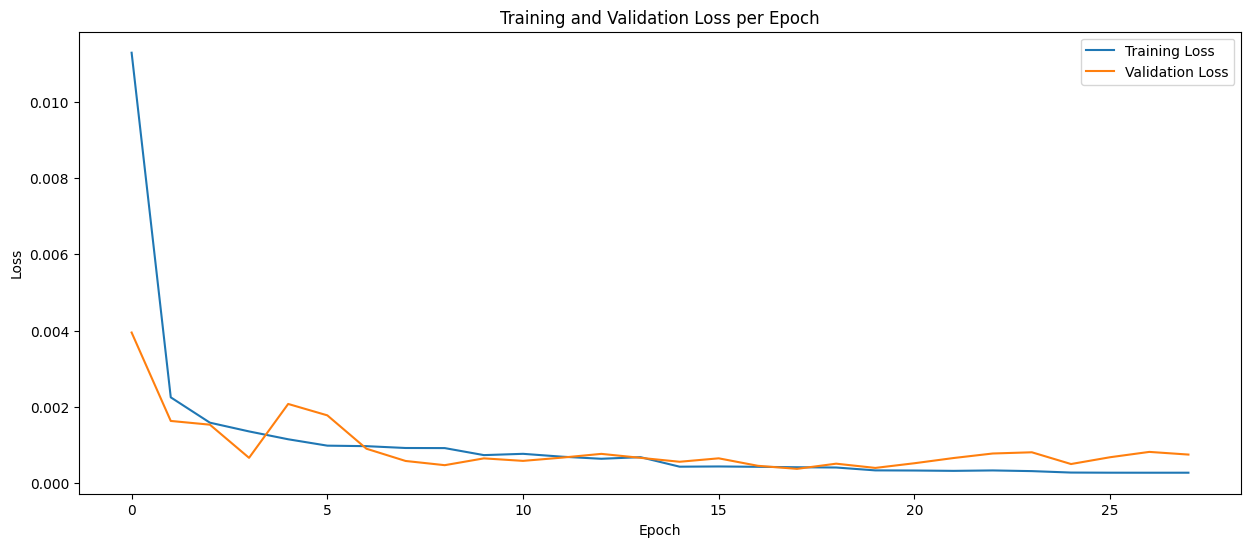

In [79]:
# Extracting loss data from the history object
train_loss = history['loss']
val_loss = history['val_loss']

# Number of epochs actually completed (may be less than 50 due to early stopping)
epochs = range(len(train_loss))

# Plotting the loss per epoch
plt.figure(figsize=(15, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [80]:
summary = []

crypto = 'BTC'
lstm = 'LSTM - Sentiment'
mse, mae, mape = evaluate(model, X_test, y_test)

summary.append({
    'Data': crypto,
    'Model': lstm,
    'MSE': mse,
    'MAE': mae,
    'MAPE': mape
})

# Convert list to DataFrame
lstm_df = pd.DataFrame(summary)
lstm_df

121/121 [==============================] - 0s 3ms/step


,Data,Model,MSE,MAE,MAPE
0,BTC,LSTM - Sentiment,0.004273,0.052252,0.279324
